# Capstone 2: Pre-Processing and Training Data

The pre-processing and training section of the data science method involves steps to improve the quality of the dataset and to select the features needed during the upcoming modeling phase. 

# Imports

Import packages.

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
import scipy.stats as stats
import sklearn as sk

Import dataset from EDA.

In [2]:
df = pd.read_csv('C:\\Users\\cssv9\\Desktop\\SB DS\\df_eda.csv')
pd.set_option('display.max_columns', None)  

# Initial Look

Explore dataframe.

In [3]:
df.head()

,Unnamed: 0,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,borough,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathroom_type,bedrooms,beds,amenities,price,price_log,instant_bookable,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,0,2595,4740.0,a few days or more,34.0,19.0,False,6.0,"['email', 'phone', 'reviews', 'offline_governm...",True,True,Midtown,Manhattan,40.75356,-73.98559,Rental unit,Entire home/apt,1,1.0,Private,1,1.0,"['Free street parking', 'Heating', 'TV', 'Dedi...",150.0,5.017280,False,30,1125,True,5,35,65,340,48,0,0,4302.0,667.0,0.33,4.70,4.72,4.62,4.76,4.79,4.86,4.41,3,3,0,0
1,1,3831,4651.0,within a day,50.0,86.0,False,1.0,"['email', 'phone', 'reviews', 'offline_governm...",True,True,Bedford-Stuyvesant,Brooklyn,40.68494,-73.95765,Other,Entire home/apt,3,1.0,Private,1,3.0,"['Dedicated workspace', 'Iron', 'Stove', 'Hair...",76.0,4.343805,False,1,730,True,0,4,9,208,408,58,0,2431.0,64.0,5.03,4.46,4.59,4.50,4.79,4.81,4.72,4.65,1,1,0,0
2,2,5136,4593.0,within a day,50.0,33.0,False,1.0,"['email', 'phone', 'reviews']",True,True,Sunset Park,Brooklyn,40.66265,-73.99454,Rental unit,Entire home/apt,4,1.5,Private,2,2.0,"['Dryer', 'BBQ grill', 'Kitchen', 'Long term s...",275.0,5.620401,False,5,1125,True,0,0,0,204,2,1,1,2799.0,24.0,0.02,5.00,5.00,5.00,5.00,5.00,4.50,5.00,1,1,0,0
3,3,5178,4565.0,within an hour,100.0,100.0,False,1.0,"['email', 'phone', 'facebook', 'reviews']",True,False,Midtown,Manhattan,40.76457,-73.98317,Rental unit,Private room,2,1.0,Private,1,1.0,"['Hot water', 'Bed linens', 'Extra pillows and...",68.0,4.234107,False,2,14,True,1,5,14,243,490,17,2,4032.0,18.0,3.64,4.21,4.20,3.73,4.66,4.40,4.86,4.36,1,0,1,0
4,4,5203,4591.0,not given,NaN,NaN,False,1.0,"['email', 'phone', 'facebook', 'google', 'revi...",True,True,Upper West Side,Manhattan,40.80380,-73.96751,Rental unit,Private room,1,1.0,Shared,1,1.0,"['Hot water', 'Smoke alarm', 'Paid parking off...",75.0,4.330733,False,2,14,True,0,0,0,0,118,0,0,3980.0,1512.0,0.89,4.91,4.83,4.82,4.97,4.95,4.94,4.92,1,0,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36818 entries, 0 to 36817
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Unnamed: 0                                    36818 non-null  int64  
 1   id                                            36818 non-null  int64  
 2   host_since                                    36707 non-null  float64
 3   host_response_time                            36818 non-null  object 
 4   host_response_rate                            21129 non-null  float64
 5   host_acceptance_rate                          21768 non-null  float64
 6   host_is_superhost                             36707 non-null  object 
 7   host_listings_count                           36707 non-null  float64
 8   host_verifications                            36818 non-null  object 
 9   host_has_profile_pic                          36707 non-null 

Drop the **Unnamed: 0** and **id** columns.

In [5]:
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('id', axis=1)

Look at the data distribution in each column

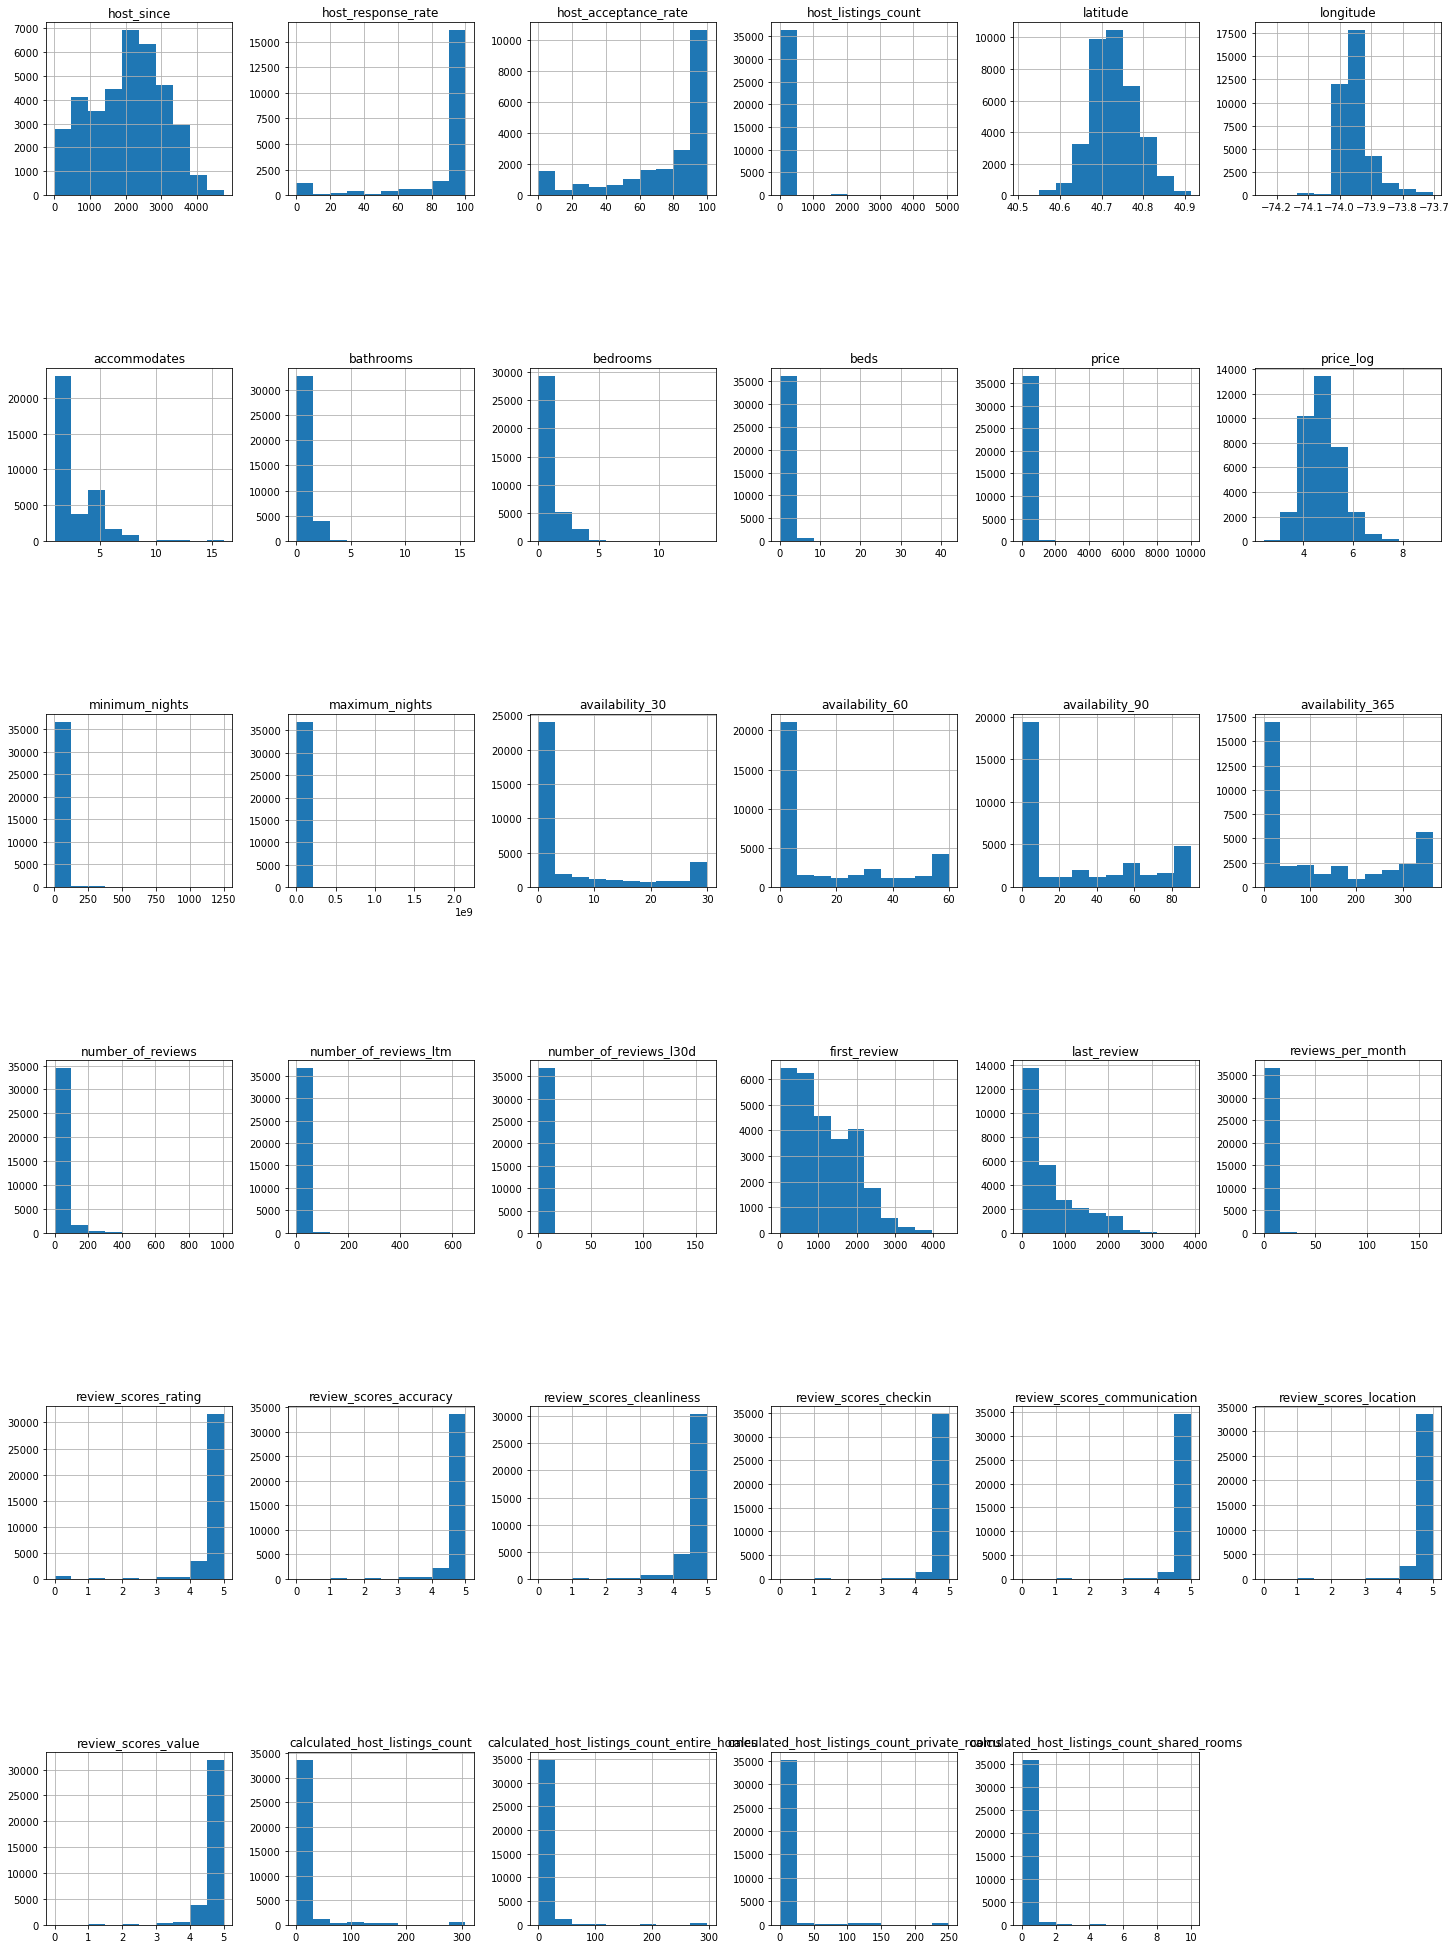

In [6]:
df.hist(figsize=(25,35))
plt.subplots_adjust(hspace=1);

Let's now look at a correlation matrix.

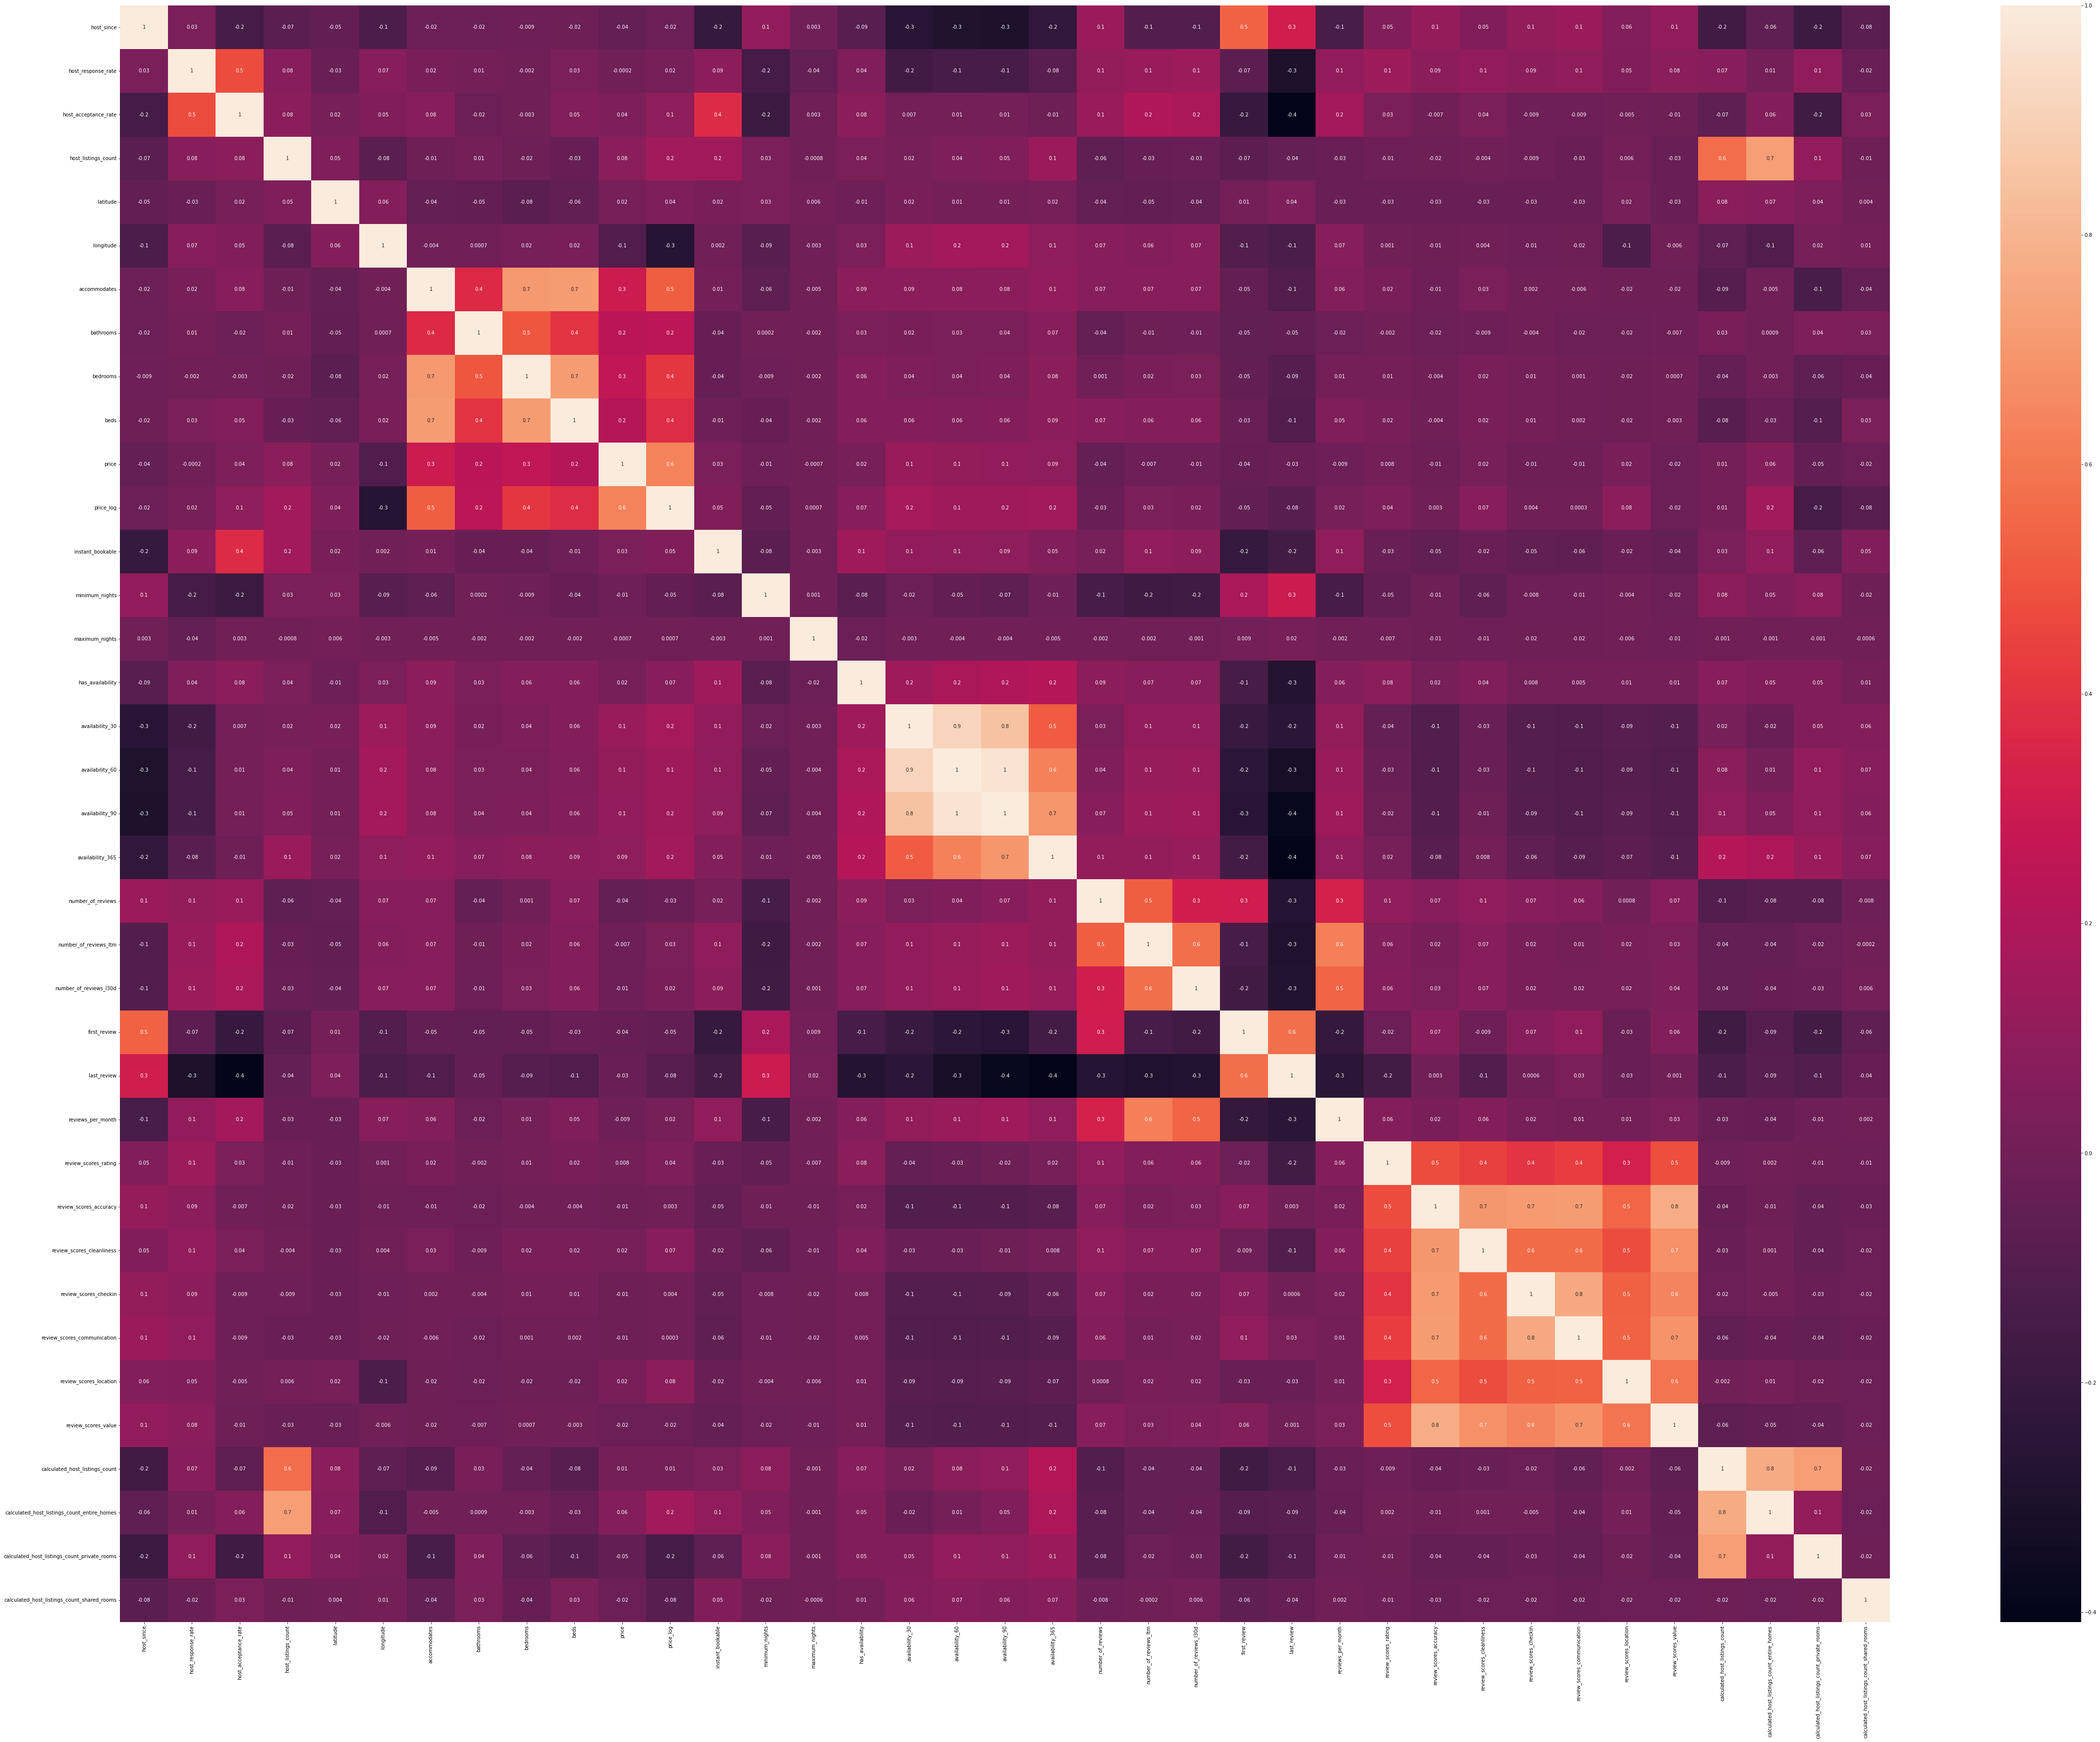

In [7]:
fig, ax = plt.subplots(figsize=(80,60))
ax = sns.heatmap(df.corr(), annot=True, fmt='0.1g')

Any independent variables highly correlated with each other are redundant. 
<br><br>
Let's look at the features that have a correlation with **price**: <br>
• beds (0.2) <br>
• bedrooms (0.3) <br>
• bathrooms (0.2) <br>
• accommodates (0.3)
<br><br>
Now, the features that have a correlation with **price_log**: <br>
• beds (0.4) <br>
• bedrooms (0.4) <br>
• bathrooms (0.2) <br>
• accommodates (0.5)

# Outliers

## Price

Let's look at the outliers for the **price** feature.

<AxesSubplot:>

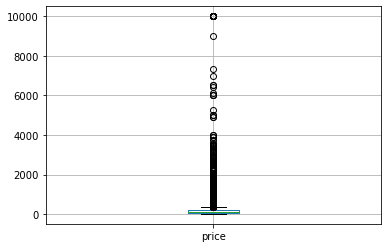

In [8]:
df.boxplot('price')

Let's look closer.

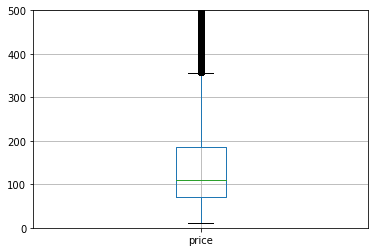

In [9]:
df.boxplot('price')
plt.ylim(0,500)
plt.show()

These outliers are greatly affecting the **price**.

To remove with the outliers in this feature, we will use quantile based outlier detection. We will follow the general rule addressing outliers in the upper limit, i.e. if a value is above the 95th quantile, then it will be considered an outlier.

In [10]:
#find the 95th quantile
q_cutoff = df['price'].quantile(0.95)

In [11]:
#Create new dataframe that only contains values up to the 95th quantile in the Price column
mask = df['price'] < q_cutoff
df2 = df[mask]

Let's take a look at the new dataframe.

In [12]:
df2.shape

(34977, 48)

In [13]:
df2['price'].max()

434.0

In [14]:
df['price'].value_counts().sort_values()

2083.0       1
1966.0       1
1264.0       1
621.0        1
1267.0       1
          ... 
80.0       777
60.0       886
50.0       906
100.0     1194
150.0     1270
Name: price, Length: 929, dtype: int64

So, the new dataframe is 1,841 rows less than the original dataframe we started with.

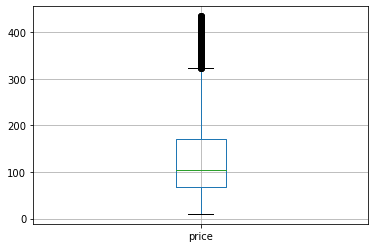

In [15]:
df2.boxplot('price')
#plt.ylim(0,500)
plt.show()

((array([-4.10960258, -3.89996883, -3.78552419, ...,  3.78552419,
          3.89996883,  4.10960258]),
  array([ 10.,  10.,  10., ..., 434., 434., 434.])),
 (78.5484266634573, 130.00314492380704, 0.939724974560033))

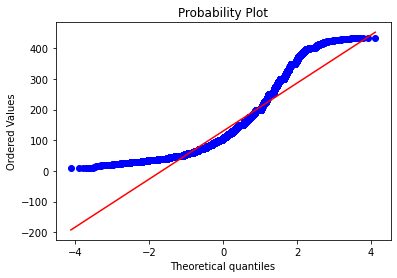

In [16]:
stats.probplot(df2['price'], dist="norm", plot=plt)

# Missing Values

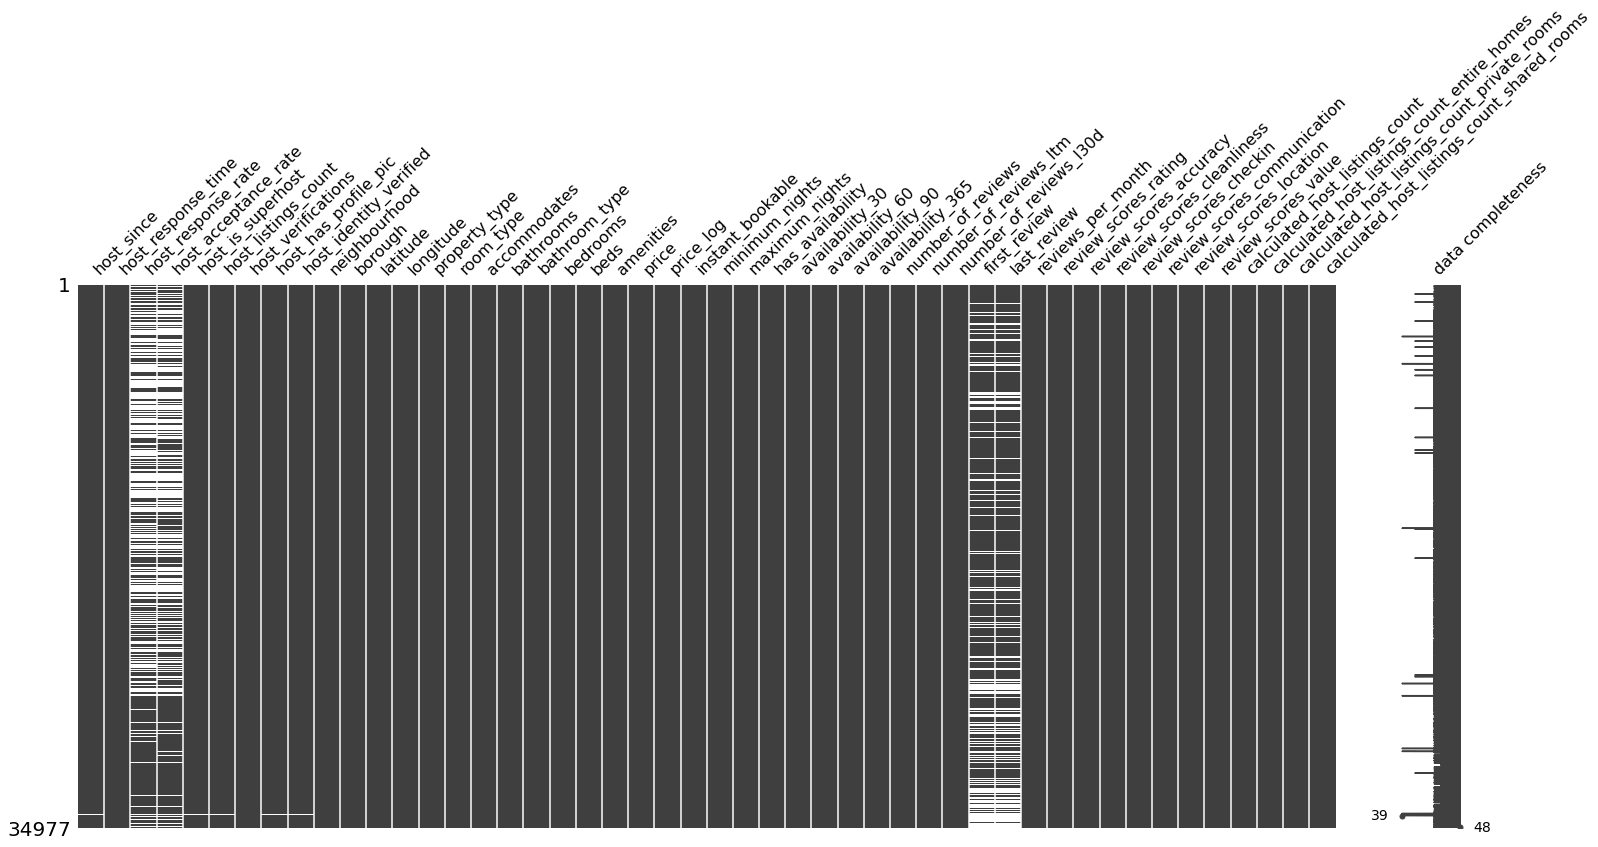

In [17]:
msno.matrix(df2, labels = True)
plt.show()

Below are the rows with missing values:

In [18]:
df2.isna().sum()

host_since                                        111
host_response_time                                  0
host_response_rate                              15207
host_acceptance_rate                            14525
host_is_superhost                                 111
host_listings_count                               111
host_verifications                                  0
host_has_profile_pic                              111
host_identity_verified                            111
neighbourhood                                       0
borough                                             0
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                                           0
bathroom_type                                       0
bedrooms                    

Noticeably, **host_response_time** has ~43% of missing values, **host_acceptance_rate** has ~41% of missing values, and **first_review** and **last_review** have ~24% missing values.

## host_since, host_is_superhost, host_has_profile_pic, host_identity_verified

Some of the columns have 111 missing values. This makes up 0.3% of the total dataset. So let's delete these rows:

In [19]:
df2 = df2.dropna(subset=['host_since'])

In [20]:
df2.shape

(34866, 48)

In [21]:
df2.isna().sum()

host_since                                          0
host_response_time                                  0
host_response_rate                              15096
host_acceptance_rate                            14414
host_is_superhost                                   0
host_listings_count                                 0
host_verifications                                  0
host_has_profile_pic                                0
host_identity_verified                              0
neighbourhood                                       0
borough                                             0
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                                           0
bathroom_type                                       0
bedrooms                    

So, those missing 111 rows are no longer in the dataset. 

## first_review & last_review

Let's now look at **first_review** and **last_review**:

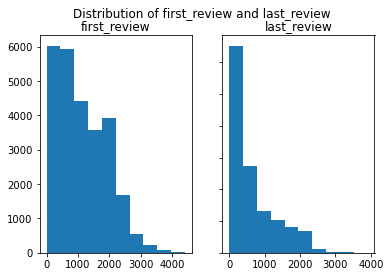

<Figure size 5760x6480 with 0 Axes>

In [22]:
#distribution of first_review and last_review
fig, ((ax1, ax2)) = plt.subplots(1, 2)
plt.figure(figsize=(80,90))

fig.suptitle('Distribution of first_review and last_review')
ax1.hist(df2['first_review'])
ax1.set_title('first_review')
ax2.hist(df2['last_review'])
ax2.set_title('last_review')

for ax in fig.get_axes():
    ax.label_outer()

The data distribution is skewed right. Thus, we cannot use the mean to fill the missing values. Let's look at the median.

In [23]:
df2['first_review'].mean(), df2['first_review'].median()

(1119.3788158937398, 1010.0)

In [24]:
df2['last_review'].mean(), df2['last_review'].median()

(613.6386174106638, 416.0)

Let's use the median values to replace the NaNs in the two columns.

In [25]:
df2['first_review'] = df2['first_review'].fillna(df2['first_review'].median())

In [26]:
df2['last_review'] = df2['last_review'].fillna(df2['last_review'].median())

So, what do the distributions look like now?

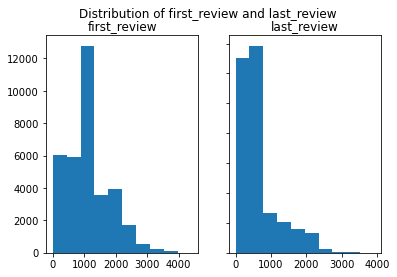

<Figure size 5760x6480 with 0 Axes>

In [27]:
#distribution of first_review and last_review post-filling-missing-values
fig, ((ax1, ax2)) = plt.subplots(1, 2)
plt.figure(figsize=(80,90))

fig.suptitle('Distribution of first_review and last_review')
ax1.hist(df2['first_review'])
ax1.set_title('first_review')
ax2.hist(df2['last_review'])
ax2.set_title('last_review')

for ax in fig.get_axes():
    ax.label_outer()

## host_response_rate & host_acceptance_rate

Consider **host_response_rate** and **host_acceptance_rate** now:

array([[<AxesSubplot:title={'center':'host_response_rate'}>]],
      dtype=object)

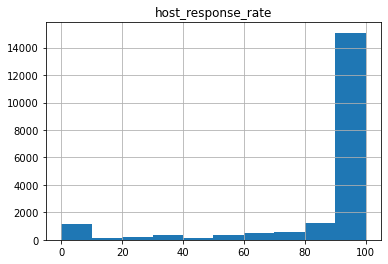

In [28]:
df2.hist('host_response_rate')

array([[<AxesSubplot:title={'center':'host_acceptance_rate'}>]],
      dtype=object)

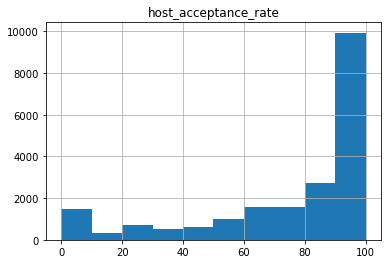

In [29]:
df2.hist('host_acceptance_rate')

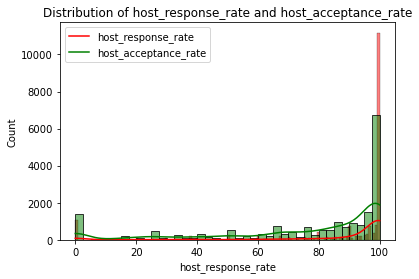

In [30]:
ax = plt.axes()
sns.histplot(df2['host_response_rate'], color='r', kde=True)
sns.histplot(df2['host_acceptance_rate'], color='g', kde=True)
ax.set_title('Distribution of host_response_rate and host_acceptance_rate')
plt.legend(labels=['host_response_rate', 'host_acceptance_rate'])
plt.show()

This data distribution has a long left tail. 

In [31]:
df2['host_response_rate'].mean(), df2['host_response_rate'].median()

(86.74087000505817, 100.0)

In [32]:
df2['host_response_rate'] = df2['host_response_rate'].fillna(df2['host_response_rate'].median())

In [33]:
df2['host_acceptance_rate'].mean(), df2['host_acceptance_rate'].median()

(75.3986896147076, 89.0)

In [34]:
df2['host_acceptance_rate'] = df2['host_acceptance_rate'].fillna(df2['host_acceptance_rate'].median())

# Label Encoding

In [35]:
#for the boolean features:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df2['host_is_superhost'] = le.fit_transform(df2['host_is_superhost'])
df2['host_identity_verified'] = le.fit_transform(df2['host_identity_verified'])
df2['host_has_profile_pic'] = le.fit_transform(df2['host_has_profile_pic'])
df2['instant_bookable'] = le.fit_transform(df2['instant_bookable'])
df2['has_availability'] = le.fit_transform(df2['has_availability'])

# Feature Scaling

We'll use StandardScaler on the numeric columns.

In [36]:
df2.head(1)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,borough,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathroom_type,bedrooms,beds,amenities,price,price_log,instant_bookable,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,4740.0,a few days or more,34.0,19.0,0,6.0,"['email', 'phone', 'reviews', 'offline_governm...",1,1,Midtown,Manhattan,40.75356,-73.98559,Rental unit,Entire home/apt,1,1.0,Private,1,1.0,"['Free street parking', 'Heating', 'TV', 'Dedi...",150.0,5.01728,0,30,1125,1,5,35,65,340,48,0,0,4302.0,667.0,0.33,4.7,4.72,4.62,4.76,4.79,4.86,4.41,3,3,0,0


In [37]:
df2 = df2.reset_index()

In [38]:
from sklearn import preprocessing

cols = ['host_since', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'price_log', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'reviews_per_month', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']
other_cols = ['host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'borough', 'property_type', 'room_type', 'bathroom_type', 'amenities', 'instant_bookable', 'has_availability']

#making a scaler object:
scaler = preprocessing.StandardScaler()

#fitting data to the scaler object
df2[cols] = pd.DataFrame(scaler.fit_transform(df2[cols]))

df2[cols].update(scaler.fit_transform(df2[cols]))

In [39]:
df2.head(3)

,index,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,borough,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathroom_type,bedrooms,beds,amenities,price,price_log,instant_bookable,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,0,2.632292,a few days or more,-2.735106,-2.548797,0,-0.122108,"['email', 'phone', 'reviews', 'offline_governm...",1,1,Midtown,Manhattan,0.435970,-0.742409,Rental unit,Entire home/apt,-1.033074,-0.333384,Private,-0.419008,-0.471562,"['Free street parking', 'Heating', 'TV', 'Dedi...",0.238578,0.534025,0,0.276966,-0.005415,1,-0.085919,0.936040,1.143893,1.600597,0.484952,-0.291859,-0.270791,4.618901,0.168566,-0.245552,0.161901,-0.073968,0.018412,-0.160688,-0.070244,0.303321,-0.562332,-0.227618,-0.114459,-0.223109,-0.113416
1,1,2.544274,within a day,-1.986809,0.204588,0,-0.152289,"['email', 'phone', 'reviews', 'offline_governm...",1,1,Bedford-Stuyvesant,Brooklyn,-0.783705,-0.185644,Other,Entire home/apt,0.201326,-0.333384,Private,-0.419008,1.550263,"['Dedicated workspace', 'Iron', 'Stove', 'Hair...",-0.646193,-0.552145,0,-0.760723,-0.005450,1,-0.600355,-0.537985,-0.541910,0.638248,7.655149,3.831131,-0.270791,1.925747,-0.840034,1.061448,-0.162006,-0.386116,-0.224769,-0.080048,-0.018449,-0.091055,-0.010334,-0.272927,-0.183513,-0.223109,-0.113416
2,2,2.486914,within a day,-1.986809,-1.973463,0,-0.152289,"['email', 'phone', 'reviews']",1,1,Sunset Park,Brooklyn,-1.179895,-0.920757,Rental unit,Entire home/apt,0.818526,1.024533,Private,1.253475,0.539351,"['Dryer', 'BBQ grill', 'Kitchen', 'Long term s...",1.733124,1.506730,0,-0.617594,-0.005415,1,-0.600355,-0.728182,-0.812843,0.609086,-0.431240,-0.220773,0.269954,2.455453,-0.906939,-0.331758,0.566785,0.598351,0.788483,0.484432,0.473595,-0.710788,0.794664,-0.272927,-0.183513,-0.223109,-0.113416


In [40]:
df2.isna().sum()

index                                           0
host_since                                      0
host_response_time                              0
host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_listings_count                             0
host_verifications                              0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood                                   0
borough                                         0
latitude                                        0
longitude                                       0
property_type                                   0
room_type                                       0
accommodates                                    0
bathrooms                                       0
bathroom_type                                   0
bedrooms                                        0


## Distribution of Price

In [41]:
#once you've done the encoding of categorical features and the standardization, you should do a correlation matrix and a PPS matrix again
#https://machinelearningknowledge.ai/predictive-power-score-vs-correlation-with-python-implementation/

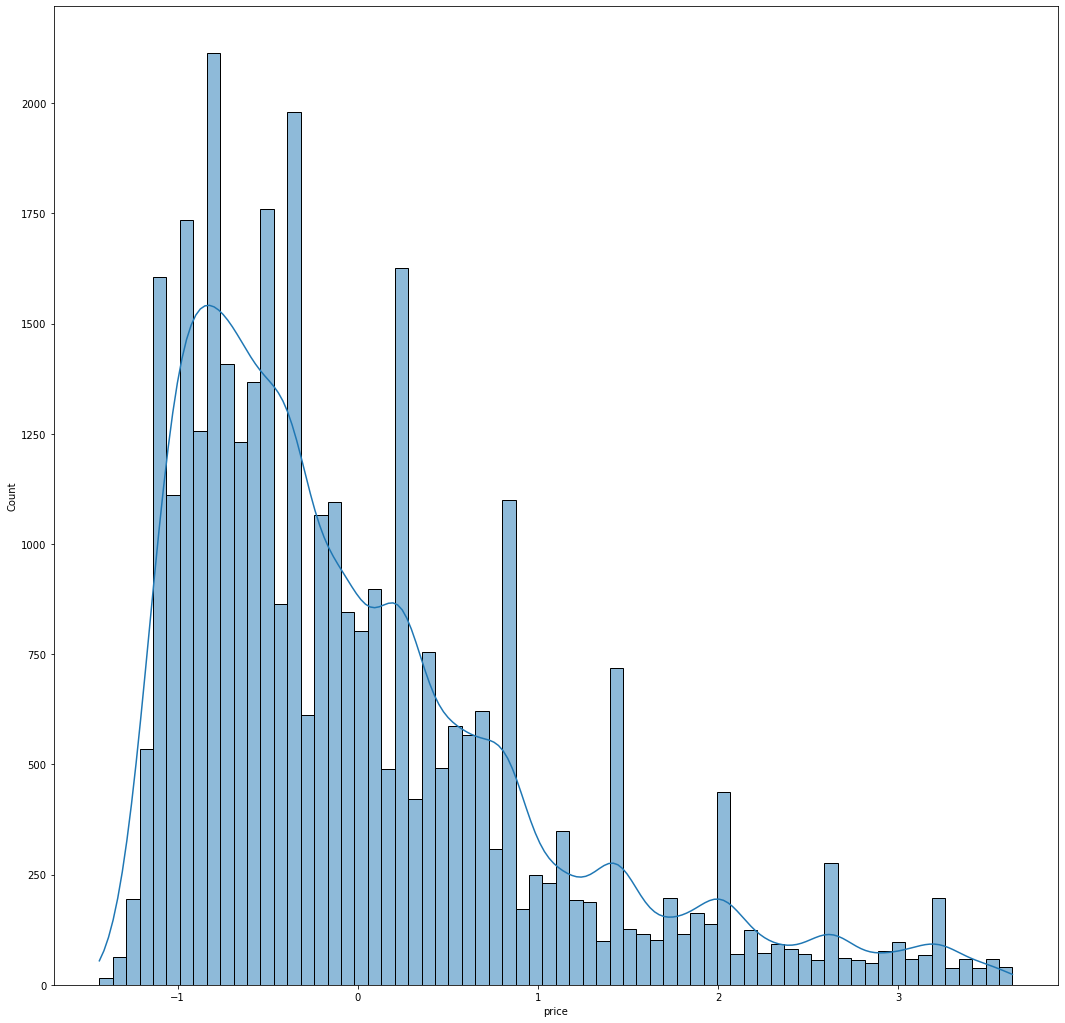

In [42]:
plt.figure(figsize=(18,18))
ax = sns.histplot(x=df2['price'], kde=True)
plt.show()

It's right skewed. But, let's note that the bumps on the right curve happen because most of the values end up being on the intervals of \\$150, \\$200, \\$250, \\$300, \\$350, and \\$400 here. 

## Standardization of *Price* Column

Now let's use log transformation to make another log price columns after all the changes we've made.

In [43]:
from sklearn.preprocessing import PowerTransformer

log = PowerTransformer()

log.fit(df2[['price']])

df2['logprice'] = log.transform(df2[['price']])

In [44]:
df3 = df2.drop('price_log', axis=1)

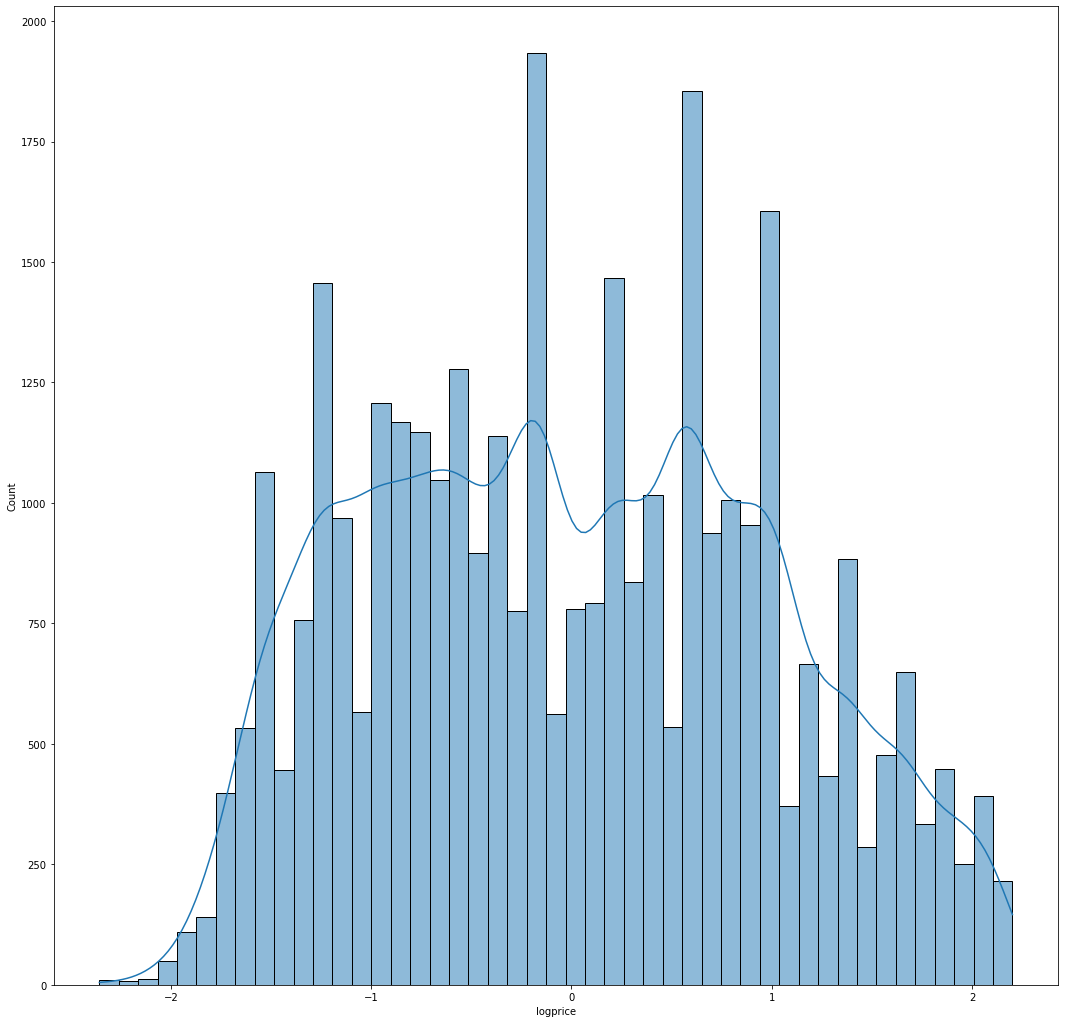

In [45]:
plt.figure(figsize=(18,18))
ax = sns.histplot(x=df3['logprice'], kde=True)
plt.show()

Taking log of the **price** column makes the data distribution resemble that of a normal distribution and removes the skewing. Hence, we will use the **logprice** column.

# OneHot Encoding (for Categorical Features)

In [46]:
df4 = pd.get_dummies(data=df3, columns=['host_response_time',
                                        'borough',
                                        'property_type',
                                        'room_type',
                                        'bathroom_type',
                                       ])

In [47]:
df4.head(2)

,index,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,instant_bookable,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,logprice,host_response_time_a few days or more,host_response_time_not given,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,property_type_Condominium (condo),property_type_Hotel,property_type_Loft,property_type_Other,property_type_Rental unit,property_type_Residential home,property_type_Serviced apartment,property_type_Townhouse,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroom_type_Private,bathroom_type_Shared,bathroom_type_Unavailable
0,0,2.632292,-2.735106,-2.548797,0,-0.122108,"['email', 'phone', 'reviews', 'offline_governm...",1,1,Midtown,0.435970,-0.742409,-1.033074,-0.333384,-0.419008,-0.471562,"['Free street parking', 'Heating', 'TV', 'Dedi...",0.238578,0,0.276966,-0.005415,1,-0.085919,0.936040,1.143893,1.600597,0.484952,-0.291859,-0.270791,4.618901,0.168566,-0.245552,0.161901,-0.073968,0.018412,-0.160688,-0.070244,0.303321,-0.562332,-0.227618,-0.114459,-0.223109,-0.113416,0.569820,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
1,1,2.544274,-1.986809,0.204588,0,-0.152289,"['email', 'phone', 'reviews', 'offline_governm...",1,1,Bedford-Stuyvesant,-0.783705,-0.185644,0.201326,-0.333384,-0.419008,1.550263,"['Dedicated workspace', 'Iron', 'Stove', 'Hair...",-0.646193,0,-0.760723,-0.005450,1,-0.600355,-0.537985,-0.541910,0.638248,7.655149,3.831131,-0.270791,1.925747,-0.840034,1.061448,-0.162006,-0.386116,-0.224769,-0.080048,-0.018449,-0.091055,-0.010334,-0.272927,-0.183513,-0.223109,-0.113416,-0.629688,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


For the **neighborhood** column, because there are so many options and we don't want to have too many features that could create noise during out modeling process, we will pick the top 20 most frequent neighborhoods. 

In [48]:
df4['neighbourhood'].value_counts().sort_values(ascending=False).head(20)

Bedford-Stuyvesant    2596
Williamsburg          2460
Harlem                1869
Bushwick              1645
Hell's Kitchen        1421
Upper West Side       1353
Upper East Side       1290
Midtown               1267
Crown Heights         1151
East Village          1125
East Harlem            726
Lower East Side        691
Greenpoint             688
Chelsea                669
Astoria                617
Washington Heights     590
West Village           482
Flatbush               422
Financial District     418
East Flatbush          391
Name: neighbourhood, dtype: int64

In [49]:
#list of top 20 neighborhoods
n_20 = [x for x in df4.neighbourhood.value_counts().sort_values(ascending=False).head(20).index]
n_20

['Bedford-Stuyvesant',
 'Williamsburg',
 'Harlem',
 'Bushwick',
 "Hell's Kitchen",
 'Upper West Side',
 'Upper East Side',
 'Midtown',
 'Crown Heights',
 'East Village',
 'East Harlem',
 'Lower East Side',
 'Greenpoint',
 'Chelsea',
 'Astoria',
 'Washington Heights',
 'West Village',
 'Flatbush',
 'Financial District',
 'East Flatbush']

In [50]:
for label in n_20:
    df4['neighbourhood' + '_' + label] = np.where(df4['neighbourhood']==label, 1, 0)

In [51]:
df4.head()

,index,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,instant_bookable,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,logprice,host_response_time_a few days or more,host_response_time_not given,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,property_type_Condominium (condo),property_type_Hotel,property_type_Loft,property_type_Other,property_type_Rental unit,property_type_Residential home,property_type_Serviced apartment,property_type_Townhouse,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroom_type_Private,bathroom_type_Shared,bathroom_type_Unavailable,neighbourhood_Bedford-Stuyvesant,neighbourhood_Williamsburg,neighbourhood_Harlem,neighbourhood_Bushwick,neighbourhood_Hell's Kitchen,neighbourhood_Upper West Side,neighbourhood_Upper East Side,neighbourhood_Midtown,neighbourhood_Crown Heights,neighbourhood_East Village,neighbourhood_East Harlem,neighbourhood_Lower East Side,neighbourhood_Greenpoint,neighbourhood_Chelsea,neighbourhood_Astoria,neighbourhood_Washington Heights,neighbourhood_West Village,neighbourhood_Flatbush,neighbourhood_Financial District,neighbourhood_East Flatbush
0,0,2.632292,-2.735106,-2.548797,0,-0.122108,"['email', 'phone', 'reviews', 'offline_governm...",1,1,Midtown,0.435970,-0.742409,-1.033074,-0.333384,-0.419008,-0.471562,"['Free street parking', 'Heating', 'TV', 'Dedi...",0.238578,0,0.276966,-0.005415,1,-0.085919,0.936040,1.143893,1.600597,0.484952,-0.291859,-0.270791,4.618901,0.168566,-0.245552,0.161901,-0.073968,0.018412,-0.160688,-0.070244,0.303321,-0.562332,-0.227618,-0.114459,-0.223109,-0.113416,0.569820,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2.544274,-1.986809,0.204588,0,-0.152289,"['email', 'phone', 'reviews', 'offline_governm...",1,1,Bedford-Stuyvesant,-0.783705,-0.185644,0.201326,-0.333384,-0.419008,1.550263,"['Dedicated workspace', 'Iron', 'Stove', 'Hair...",-0.646193,0,-0.760723,-0.005450,1,-0.600355,-0.537985,-0.541910,0.638248,7.655149,3.831131,-0.270791,1.925747,-0.840034,1.061448,-0.162006,-0.386116,-0.224769,-0.080048,-0.018449,-0.091055,-0.010334,-0.272927,-0.183513,-0.223109,-0.113416,-0.629688,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2.486914,-1.986809,-1.973463,0,-0.152289,"['email', 'phone', 'reviews']",1,1,Sunset Park,-1.179895,-0.920757,0.818526,1.024533,1.253475,0.539351,"['Dryer', 'BBQ grill', 'Kitchen', 'Long term s...",1.733124,0,-0.617594,-0.005415,1,-0.600355,-0.728182,-0.812843,0.609086,-0.431240,-0.220773,0.269954,2.455453,-0.906939,-0.331758,0.566785,0.598351,0.788483,0.484432,0.473595,-0.710788,0.794664,-0.272927,-0.183513,-0.223109,-0.113416,1.525287,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,2.459223,0.351620,0.779922,0,-0.152289,"['email', 'phone', 'facebook', 'reviews']",1,0,Midtown,0.631665,-0.694185,-0.415874,-0.333384,-0.419008,-0.471562,"['Hot water', 'Bed linens', 'Extra pillows and...",-0.741844,0,-0.724941,-0.005512,1,-0.497468,-0.490436,-0.391392,0.893417,9.288361,0.916603,0.810699,4.230258,-0.916975,0.674910,-0.499410,-1.322560,-1.78517

In [52]:
df4 = df4.drop('neighbourhood', axis=1)

In [53]:
df4 = df4.drop('index', axis=1)

## Host Verifications

Firstly, what are the unique methods of host verification available to us?

In [54]:
#Separating all the individual verification methods

from ast import literal_eval

all_verfs = [value for sublist in df4['host_verifications'].apply(lambda row: literal_eval(row)) for value in sublist]

from collections import Counter

result = Counter(all_verfs)
result

Counter({'email': 32129,
         'phone': 34721,
         'reviews': 21436,
         'offline_government_id': 15616,
         'kba': 7582,
         'selfie': 10224,
         'government_id': 21743,
         'identity_manual': 9336,
         'work_email': 4946,
         'facebook': 6427,
         'google': 1498,
         'jumio': 13881,
         'sent_id': 50,
         'manual_offline': 462,
         'manual_online': 228,
         'weibo': 24,
         'sesame': 23,
         'sesame_offline': 23,
         'zhima_selfie': 12})

Let's only consider the top 5 most common verification methods:

In [55]:
result.most_common(5)

[('phone', 34721),
 ('email', 32129),
 ('government_id', 21743),
 ('reviews', 21436),
 ('offline_government_id', 15616)]

Now, let's split the lists using the "strip" and "replace" string methods:

In [56]:
df4['host_verifications'] = df4['host_verifications'].str.strip("[").str.strip("]").str.replace("'", "")

In [57]:
df4['hv_email'] = df4['host_verifications'].map(lambda x: 1 if 'email' in x else 0)

In [58]:
df4['hv_phone'] = df4['host_verifications'].map(lambda x: 1 if 'phone' in x else 0)

In [59]:
df4['hv_reviews'] = df4['host_verifications'].map(lambda x: 1 if 'reviews' in x else 0)

In [60]:
df4['hv_govid'] = df4['host_verifications'].map(lambda x: 1 if 'government_id' in x else 0)

In [61]:
df4['hv_offline_govid'] = df4['host_verifications'].map(lambda x:1 if 'offline_government_id' in x else 0)

Thus, let's drop the **host_verifications** column

In [62]:
df4 = df4.drop('host_verifications', axis=1)

## Amenities

Let's split the lists using the "strip" and "replace" string methods:

In [63]:
df4['amenities'] = df4['amenities'].str.strip("[").str.strip("]").str.replace("'", "")

In the EDA section, we determined that long-term stays, the provision of a kitchen, air conditioniing, hangers, and free street parking have an influence on the price of a listing.

In [64]:
df4['has_kitchen'] = df4['amenities'].map(lambda x: 1 if 'Kitchen' in x else 0)

In [65]:
df4['has_longtermstays'] = df4['amenities'].map(lambda x:1 if 'Long term stays allowed' in x else 0)

In [66]:
df4['has_ac'] = df4['amenities'].map(lambda x:1 if 'Air conditioning' in x else 0)

In [67]:
df4['has_hangers'] = df4['amenities'].map(lambda x:1 if 'Hangers'in x else 0)

In [68]:
df4['has_freestreetparking'] = df4['amenities'].map(lambda x:1 if 'Free street parking' in x else 0)

Thus, let's drop the **amenities** column.

In [69]:
df4 = df4.drop('amenities', axis=1)

In [70]:
df4.head()

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,instant_bookable,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,logprice,host_response_time_a few days or more,host_response_time_not given,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,property_type_Condominium (condo),property_type_Hotel,property_type_Loft,property_type_Other,property_type_Rental unit,property_type_Residential home,property_type_Serviced apartment,property_type_Townhouse,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroom_type_Private,bathroom_type_Shared,bathroom_type_Unavailable,neighbourhood_Bedford-Stuyvesant,neighbourhood_Williamsburg,neighbourhood_Harlem,neighbourhood_Bushwick,neighbourhood_Hell's Kitchen,neighbourhood_Upper West Side,neighbourhood_Upper East Side,neighbourhood_Midtown,neighbourhood_Crown Heights,neighbourhood_East Village,neighbourhood_East Harlem,neighbourhood_Lower East Side,neighbourhood_Greenpoint,neighbourhood_Chelsea,neighbourhood_Astoria,neighbourhood_Washington Heights,neighbourhood_West Village,neighbourhood_Flatbush,neighbourhood_Financial District,neighbourhood_East Flatbush,hv_email,hv_phone,hv_reviews,hv_govid,hv_offline_govid,has_kitchen,has_longtermstays,has_ac,has_hangers,has_freestreetparking
0,2.632292,-2.735106,-2.548797,0,-0.122108,1,1,0.435970,-0.742409,-1.033074,-0.333384,-0.419008,-0.471562,0.238578,0,0.276966,-0.005415,1,-0.085919,0.936040,1.143893,1.600597,0.484952,-0.291859,-0.270791,4.618901,0.168566,-0.245552,0.161901,-0.073968,0.018412,-0.160688,-0.070244,0.303321,-0.562332,-0.227618,-0.114459,-0.223109,-0.113416,0.569820,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
1,2.544274,-1.986809,0.204588,0,-0.152289,1,1,-0.783705,-0.185644,0.201326,-0.333384,-0.419008,1.550263,-0.646193,0,-0.760723,-0.005450,1,-0.600355,-0.537985,-0.541910,0.638248,7.655149,3.831131,-0.270791,1.925747,-0.840034,1.061448,-0.162006,-0.386116,-0.224769,-0.080048,-0.018449,-0.091055,-0.010334,-0.272927,-0.183513,-0.223109,-0.113416,-0.629688,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
2,2.486914,-1.986809,-1.973463,0,-0.152289,1,1,-1.179895,-0.920757,0.818526,1.024533,1.253475,0.539351,1.733124,0,-0.617594,-0.005415,1,-0.600355,-0.728182,-0.812843,0.609086,-0.431240,-0.220773,0.269954,2.455453,-0.906939,-0.331758,0.566785,0.598351,0.788483,0.484432,0.473595,-0.710788,0.794664,-0.272927,-0.183513,-0.223109,-0.113416,1.525287,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0
3,2.459223,0.351620,0.779922,0,-0.152289,1,0,0.631665,-0.694185,-0.415874,-0.333384,-0.419008,-0.471562,-0.741844,0,-0.724941,-0.005512,1,-0.497468,-0.490436,-0.391392,0.893417,9.288361,0.916603,0.810699,4.230258,-0.916975,0.674910,-0.499410,-1.322560,-1.785177,-0.429487,-1.080230,0.303321,-0.677332,-0.272927,-0.218040,-0.189368,-0.113416,-0.806431,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1
4,2.484936,0.351620,0.327874,0,-0.152289,1,1,1.328952,-0.382126,-1.033074,-0.333384,-0.419008,-0.471562,-

# Train-Test Split

Now, let's split the data into training and test sets. 
<br><br>
Remember, we have decided to use **logprice** as it was closer to a normal distribution than the **price** feature.

In [71]:
#extract features and labels
X = df4.drop('logprice', axis=1)
y = df4['logprice']

#create training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)